Details in some calculation in our algorithm:

Step 1: Calculate H matrix:  $ H = \sum_{ \{x_i, x_j \} \in C}(x_i - x_j)(x_i - x_j)^T $
Where C denote the close set, i.e., the pair of points  are similar to each other. 


Step 2: Let $X_{\tau_{i,j},  \{x_i, x_j \} \in F} = (x_i - x_j)(x_i - x_j)^T$ 
Where F denote the Far set, i.e., the pair of points are dissimilar to each other.  In our algorithm, the far_set = close_set are just all pairs of the points in the point set. (one point denote one observation)


Calculate $\tilde{X}_{\tau_{i,j}, \{x_i, x_j \} \in F}$: $\tilde{X}_{\tau_{i,j}, \{x_i, x_j \} \in F} = H^{-\frac{1}{2}} X_{\tau_{i,j}, \{x_i, x_j \} \in F} H^{-\frac{1}{2}} \cdot \textbf{weight_function}(X,i,j)$ The weight function include: Gaussian kernel weight, laplacian kernel weight, inverse weight.



Step 3: Calculate gradient as $G = \frac{\sum_{\tau \in F} \exp(- <\tilde{X}_{\tau}, M> / \sigma)\tilde{X}_{\tau}}{\sum_{\tau \in F}\exp(- <\tilde{X}_{\tau}, M> / \sigma)}$


Then run algorithm as below:

Initialize $M_0 = I$

for t = 1,2,3, $\cdots$ T do:
    
    Calculate $G(M_{t-1})$ as in step 3
    let v_t be the maximal eigenvector of $G(M_{t-1})$
    Update M_t by M_t = (t - 1)/t * M_(t-1) + (d/t) * v_t * v_t^{T}


Return M_T






In [1]:
import plotly as plty
from plotly import express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff
import pandas as pd 
cmap = px.colors.diverging.Spectral

In [2]:
from google.colab import drive
root = "/content/drive"
drive.mount(root)
import os 
os.chdir("/content/drive/My Drive/combustion data")
import pandas as pd 

Mounted at /content/drive


In [3]:
import os 
os.chdir("PCAfold")
os.listdir()
!python setup.py build_ext --inplace
!python setup.py install
from PCAfold import PCA
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
from PCAfold import KReg

import numpy as np

import matplotlib.pyplot as plt
import pickle
import multiprocessing as multiproc

import plotly as plty
from plotly import express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff

Compiling PCAfold/kernel_regression_cython.pyx because it depends on /usr/local/lib/python3.7/dist-packages/Cython/Includes/libc/string.pxd.
[1/1] Cythonizing PCAfold/kernel_regression_cython.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/combustion data/PCAfold/PCAfold/kernel_regression_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'PCAfold.kernel_regression' extension
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/PCAfold
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=form

In [4]:
X_dict = pickle.load(open('transient-H2-air-flamelet-vars.p'         ,'rb'))
S_dict = pickle.load(open('transient-H2-air-flamelet-source-terms.p' ,'rb'))



nthSpecies = 'N2'
exclude = [nthSpecies]

varNames_full = [name for name in S_dict.keys() if name not in exclude]
X   = np.hstack([X_dict[name][None].T for name in varNames_full])
S_X = np.hstack([S_dict[name][None].T for name in varNames_full])


X, i_removed, i_retained = preprocess.remove_constant_vars(X)
S_X = S_X[:,i_retained]
varNames = list(np.array(varNames_full)[i_retained])

In [5]:
ncomp = 3
scaling = 'vast'
pcaObj = reduction.PCA(X, scaling=scaling, n_components=ncomp)
X_scaled = np.zeros_like(X)
S_X_scaled = np.zeros_like(X)
for i in range(X.shape[1]):
    X_scaled[:,i] = (X[:,i] - pcaObj.X_center[i])/pcaObj.X_scale[i]
    S_X_scaled[:,i] = S_X[:,i]/pcaObj.X_scale[i]

pca_x = pcaObj.transform(X_scaled)
pca_s_x = pcaObj.transform(S_X_scaled)

In [61]:
np.amax(S_X_scaled,axis = 0)

array([2.24211283e+05, 6.42155148e+05, 3.82028250e+02, 6.70225084e+05,
       3.67528012e+05, 3.80822627e+05, 3.05741081e+01, 1.02082599e+06,
       6.47735487e+05])

In [62]:
np.amax(X_scaled,axis = 0)

array([4.26401982, 2.69498384, 2.70467717, 2.46831576, 2.06880624,
       1.82002904, 1.78941412, 2.44487325, 2.71797058])

In [ ]:
"""
unit vector of source term ... 
...

3 from scaled.. 
3 from unit
span of 3 
down to 3 ... 

3 ... weight of extra unit vector smaller enough not drastically affect r_2 
... 
"""


In [ ]:
from scipy.stats import gaussian_kde
density = gaussian_kde(S_X_scaled[:,0])
xs = np.linspace(0,np.max(S_X_scaled[:,0]),1000)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

In [31]:
S_x_1 = S_X_scaled[np.ix_(S_X_scaled[:,1] > 100000,np.array([True for _ in range(9)]))]

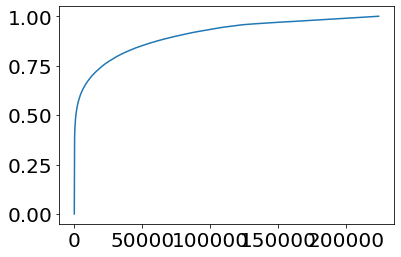

In [38]:
from scipy.stats import gaussian_kde
density = gaussian_kde(S_X_scaled[:,0])
xs = np.linspace(np.min(S_X_scaled[:,0]),np.max(S_X_scaled[:,0]),1000)
density.covariance_factor = lambda : .25
density._compute_covariance()
from scipy.special import ndtr
stdev = np.sqrt(density.covariance)[0, 0]
pde_cdf = ndtr(np.subtract.outer(xs,S_X_scaled[:,0])).mean(axis=1)
plt.plot(xs, pde_cdf)
plt.show()

In [34]:
min(X_scaled[:,0])

-4.332600043964898

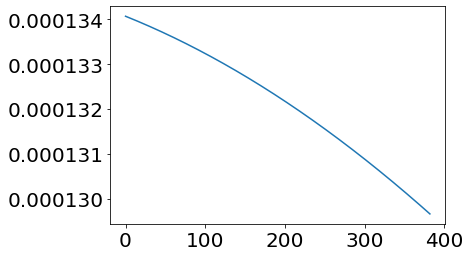

In [10]:
density = gaussian_kde(S_X_scaled[:,1])
xs = np.linspace(0,np.max(S_X_scaled[:,1]),1000)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

In [ ]:
density = gaussian_kde(S_X_scaled[:,0])
xs = np.linspace(0,np.max(S_X_scaled[:,0]),1000)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

Below the implementation of DML algorithm

To see different shape please tune the smoothing parameter inside optimize_dml function

In [6]:
# far_set: list of list, e.g [[0,1],[1,2]] ... 
# close_set: list of list, e.g. [[2,3],[3,4]] ... 
# in this setting far_set == close_set == pairwise all points 
import numpy as np
import math
import itertools
import numba
from numba import jit,generated_jit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.linalg import sqrtm
from sklearn import preprocessing
from tqdm import tqdm
# Generate pairwise point set by create_sub_set function as below... 
# e.g: input [1,2,3] return [[1,2],[1,3],[2,3]]
def create_sub_set(nums):
    result = []
    def dfs(res, temp, nums, index):
        if len(temp) > 2:
            return 
        if len(temp) == 2:
            res.append(list(temp))
            return 
        for i in range(index, len(nums)):
            temp.append(nums[i])
            dfs(res, temp, nums, i + 1)
            temp.pop()
    dfs(result, [], nums, 0)
    return np.array(result)


# The function to calculate outer product between i_th and j_th observation in X
@jit(nopython = True)
def calculate_outer_product(X,i,j):
    return np.outer((X[i,:] - X[j, :]), (X[i,:] - X[j, :]))

@jit(nopython = True)
def change_to_psd(m, gamma):
    value, vector = np.linalg.eig(m)
    value = np.real(value)
    vector = np.real(vector)
    value = np.maximum(value, gamma * np.ones(len(value)))
    psd_matrix = vector @ np.diag(value) @ np.linalg.inv(vector)
    return psd_matrix

# The function to calculate H matrix in step 1 
@jit(nopython = True)
def calculate_H(X, close_set, delta):
    n, d = X.shape
    result = np.zeros(shape = (d, d))
    for l in range(len(close_set)):
        i = close_set[l][0]
        j = close_set[l][1]
        result += 2 * calculate_outer_product(X,i,j)
    psd_mat = change_to_psd(result, delta)
    return psd_mat 


    # The function to calculate gradient G matrix in step 3 
# H^{-1/2} is actually calculated by cholesky decompostion of H = LL^{*} and take inverse mutiply (X[i]-X[j]), the detail can be seen in "Distance Metric Learning with Eigenvalue Optimization"
@jit(nopython=True)
def calculate_g_delta(X, W_X, far_set, sigma, M, H, b, weight_option):
    n, d = X.shape
    numerator = np.zeros(shape =(d,d))
    denominator = np.zeros(shape = (d,d))
    L = np.linalg.cholesky(H)
    H_inverse_half  = np.linalg.inv(L)
    if weight_option == "Gaussian":
      for l in range(len(far_set)):
          i = far_set[l][0]
          j = far_set[l][1]
          x_gamma_hat = H_inverse_half @ (X[i,:] - X[j, :]).reshape((d,1)) @ (X[i,:] - X[j, :]).reshape((1,d)) @ H_inverse_half.T * (1 - np.exp(-np.sum((W_X[i,:] - W_X[j,:])**2) / b**2))
          numerator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma)) * x_gamma_hat  
          denominator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma))
    elif weight_option == "Laplacian":
      for l in range(len(far_set)):
          i = far_set[l][0]
          j = far_set[l][1]
          x_gamma_hat = H_inverse_half @ (X[i,:] - X[j, :]).reshape((d,1)) @ (X[i,:] - X[j, :]).reshape((1,d)) @ H_inverse_half.T * (1 - np.exp(-np.linalg.norm(W_X[i,:] - W_X[j,:], ord = 1) / b**2))
          numerator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma)) * x_gamma_hat  
          denominator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma))
    else:
      for l in range(len(far_set)):
          i = far_set[l][0]
          j = far_set[l][1]
          x_gamma_hat = H_inverse_half @ (X[i,:] - X[j, :]).reshape((d,1)) @ (X[i,:] - X[j, :]).reshape((1,d)) @ H_inverse_half.T * (1 / max(1e-8, np.sum((W_X[i,:] - W_X[j,:])**2)**0.25))
          numerator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma)) * x_gamma_hat  
          denominator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma))
 
    q = numerator / denominator 
    return q 


def optimize_dml(X, W_X, b, projection_dimension, sigma, epoch = 50, column_weight = None, weight_option = None, percentile = 0.05, standardize = True, sampling_by_cluster = False, n_clusters = 2):
    """
    Input arguments: 
    X: data used to learn the transformation, usually a certain percentile, say 0.05 would be extracted from this X to learn the final transformation
    W_X: data used in weight function 
    b: the bandwidth in kernel weight or laplace weight function.
    projection_dimension: The number of projection dimensions used for the transformation. 
    epoch: the iterations for the algorithm - 1
    weight_option: Three types of weight function can be chosen: "Gaussian", "Laplacian", "Inverse"
    percentile: the percentile of the data used to learn transformation, default is 0.05 
    standardize: standardize data or not before learning transformation, default is True
    column_weight: default is None, mean column has same weight, else should be list of positive number, the length must be equal to number of column

    Return: 
    m: the transformation matrix learnt by algorithm, the dimension will be (projection_dimension, projection_dimension)
    buffer ... 
    example: 
    from sklearn import preprocesing
    m = optimize_dml(X[:,i_retained], 1e-5, 3) 
    transformed_mat = preprocessing.scale(X[:, i_retained]) @ m 
    """
    # hardcode parameters 
    n, d = X.shape
    stop_tolerance = 1e-5
    delta = 1e-5
    smooth_parameter = d * sigma

    # create the subset used in learning the transformation, based on the X and Percentile
    if sampling_by_cluster == False:
        X = X[np.arange(0, n, int(1/percentile)), :] 
        W_X = W_X[np.arange(0, n, int(1/percentile)), :]
    else:
        km =  KMeans(n_clusters=n_clusters, random_state=42).fit(X)
        l = km.labels_
        X = np.hstack((X,np.arange(X.shape[0]).reshape(X.shape[0],1)))
        _, X, _, _ = train_test_split(X, l, test_size = percentile, random_state = 42, stratify = l)
        W_X = W_X[[int(s) for s in X[:,-1]],:]
        X = X[:, :X.shape[1]-1]


    # create the far_set and close_set in data to represent pairwise similiarity 
    # currently for our algorithm, all the pairs are close_set and all the pairs are far_set. 
    close_set = create_sub_set(np.arange(0, X.shape[0]))
    far_set = create_sub_set(np.arange(0, X.shape[0]))

    # determine if the data should be standardize or not, means (x - mean(x))/sigma(x)
    if standardize == True:
        X = preprocessing.scale(X)
        #W_X = preprocessing.scale(X)

    # determine if the user-input of column weight will be applied or not. 
    if column_weight != None:
        if len(column_weight) != d:
            print("The column_weight input is incorrect \n")
            print("use default weight")
        else:
            X = X @ np.diag(column_weight)

    # calculate H matrix as in step 1 described in above cell 
    
    H = calculate_H(X, close_set, delta)
    print(np.trace(H))
    # initialize the M matrix M_0
    M = np.eye(d)
    err_buff = [] #... 
    # below is the implementation of algorithm shown in the description above this cell
    for i in tqdm(range(1, epoch)):
        # calculate gradient matrix G
        g = calculate_g_delta(X, W_X, far_set, smooth_parameter, M, H, b, weight_option)
        # find max eigenvector v_t 
        w,v = np.linalg.eig(g) 
        index_max = np.argmax(w)
        v_t = np.real(v[:, index_max])

        # update the matrix M 
        M_new = (i - 1) / i * M + (d / i) * np.outer(v_t, v_t) 
        err = (np.sum(M_new - M))**2
        print("\n")
        print("erros is ", err)
        print("\n")
        if len(err_buff) == 3:
            err_buff.pop(0)
            err_buff.append(err)
        else:
            err_buff.append(err)
        if len(err_buff) == 3 and np.mean(err_buff) <= stop_tolerance:
            print("A")
            M = M_new
            break
        else:
            M = M_new 

    # pick the top k eigenvector from M and return. 
    val, vec = np.linalg.eig(M)
    top_k_index = val.argsort()[-projection_dimension:][::-1]
    return vec[:, np.array(top_k_index)]


In [7]:
from sklearn.kernel_ridge import KernelRidge
def run_kernel_regression(train_x, train_y, test_x, test_y, alpha, gamma):
    n_dim = train_y.shape[1]
    pred_y = np.zeros((test_y.shape[0],test_y.shape[1]))
    rmse = []
    l_inf = []
    r_2 = []
    #clf = KernelRidge(alpha=1.0, kernel = "rbf").fit(transformed_mat[index,:], transformed_srcs[index,0])
    for i in range(n_dim):
        clf = KernelRidge(alpha=alpha, kernel = "rbf", gamma = gamma).fit(train_x, train_y[:,i])
        pred_y[:,i] = clf.predict(test_x)
        r_square = clf.score(test_x, test_y[:,i])
        r_2.append(r_square)
        rmsr = (np.sum((pred_y[:,i] - test_y[:,i])**2) / pred_y.shape[0]) ** 0.5
        rmse.append(rmsr)
        inf = np.max(np.abs(pred_y[:, i] - test_y[:,i]))
        l_inf.append(inf)
    return pred_y, rmse, l_inf, r_2

In [16]:
from tabulate import tabulate 
def short_result(X, Y, P, P2, kfold, alpha, gamma, peak_for_all = False):
    """
    run the diagnostic on subsample
    X:  x @ M
    Y:  y @ M
    P:  percentile 

    return cv_error, r_square_value, len of list 
    """



    n = X.shape[0]
    r1_index = np.random.choice(n, size = int(n * P), replace= False)
    X_1 = X[r1_index,:]
    X_2 = np.delete(X, r1_index, axis = 0)
    Y_1 = Y[r1_index, :]
    Y_2 = np.delete(Y, r1_index, axis = 0)

    random_index = np.random.choice(n, size = int(n * P2), replace= False)
    Xs = X[random_index, :]
    Ys = Y[random_index, :]


    n1 = X_1.shape[0]
    random_order = np.random.choice(n1, size = n1, replace= False)
    X_cv = X[random_order, :]
    Y_cv = Y[random_order, :]
    cv_error = {}
    cv_error["rmse " + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    cv_error["r_square " + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    cv_error["l_inf " + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    for i in tqdm(range(kfold)):
        index = [s for s in range(int(i / kfold * n1),int((i + 1)/kfold * n1))]
        X_test = X_cv[np.array(index), :]
        X_train = np.delete(X_cv, index, axis = 0)
        Y_test = Y_cv[np.array(index), :]
        Y_train = np.delete(Y_cv, index, axis = 0)
        _, rmse, l_inf, r_2 = run_kernel_regression(X_train, Y_train, X_test, Y_test, alpha, gamma)
        cv_error["rmse " + str(kfold) + " fold AVG"] = (cv_error["rmse " + str(kfold) + " fold AVG"] * i + np.array(rmse)) / (i + 1)
        cv_error["r_square " + str(kfold) + " fold AVG"] = (cv_error["r_square " + str(kfold) + " fold AVG"] * i + np.array(r_2)) / (i + 1)
        cv_error["l_inf " + str(kfold) + " fold AVG"] =  (cv_error["l_inf " + str(kfold) + " fold AVG"] * i + np.array(l_inf)) / (i + 1)
    
    p = pd.DataFrame(cv_error)
    print("\n")
    print("Cross-Validation Statistics of " + str(P * 100) +" percent random subsample")
    p.index = ["projected dimension " + str(i + 1) for i in range(Y.shape[1])]
    #print("\n")
    print(tabulate(p, headers = 'keys', tablefmt = 'psql'))
    print("\n")
    """
    compute peak location for subsample
    """
    bandwidth_values = np.logspace(-3.5, 0.5, 25)
    depvar_names = ['$S_{DML_' + str(i) + '}$' for i in range(Xs.shape[1])]
    variance_data = analysis.compute_normalized_variance(Xs,
                                                     Ys,
                                                     depvar_names=depvar_names,
                                                     bandwidth_values=bandwidth_values,
                                                     n_threads=4
                                                    )
    der, sig = analysis.normalized_variance_derivative(variance_data)
    print("Peak locations of the " + str(P2 * 100) +" percent random subsample")
    for depvar_name in depvar_names:
        peak_locs, peak_vals = analysis.find_local_maxima(der[depvar_name], sig, show_plot=False)
        print(depvar_name, 'peak locations:', peak_locs)
    
    if peak_for_all == True:
        """
        compute peak for all data
        """
        print("\n")
        depvar_names = ['$S_{DML_' + str(i) + '}$' for i in range(X.shape[1])]
        variance_data = analysis.compute_normalized_variance(X,
                                                     Y,
                                                     depvar_names=depvar_names,
                                                     bandwidth_values=bandwidth_values,
                                                     n_threads=4
                                                    )
        der, sig = analysis.normalized_variance_derivative(variance_data)
        print("Peak locations of the whole dataset")
        for depvar_name in depvar_names:
            peak_locs, peak_vals = analysis.find_local_maxima(der[depvar_name], sig, show_plot=False)
            print(depvar_name, 'peak locations:', peak_locs)




    
    
    pred, a, b, c = run_kernel_regression(X_1, Y_1, X_2, Y_2, alpha, gamma)
    print("\n")
    print("Train/Test random split ratio as " + str(P * 100) + "/" + str((1- P) * 100))
    test_statistics = {}
    test_statistics["rmse"] = a
    test_statistics["r_square"] = c
    test_statistics["l_inf"] = b
    q = pd.DataFrame(test_statistics)
    q.index = ["projected dimension " + str(i + 1) for i in range(Y.shape[1])]
    print(tabulate(q, headers = 'keys', tablefmt = 'psql')) 
    return cv_error, a, b, c, pred, Y_2
        



below is the function with clustering sampling
the number cluster is 2 

In [9]:
bw = 1e-3
m = optimize_dml(X = S_X_scaled, W_X = S_X_scaled, b = bw, projection_dimension= 4, sigma = 1e-7, column_weight=None, weight_option="ELSE", percentile=0.2, sampling_by_cluster=True, n_clusters=4)
m = np.real(m)
wx = S_X_scaled @ m 
m1 = optimize_dml(X = S_X_scaled, W_X = wx, b = bw, projection_dimension=3, sigma=1e-7, column_weight=None, weight_option="ELSE", percentile=0.2, sampling_by_cluster=True, n_clusters=4)
np.savetxt("m_1e-7_linear.csv", m, delimiter=",")
np.savetxt("m1_1e-7_linear.csv", np.real(m1), delimiter=",")

  0%|          | 0/49 [00:00<?, ?it/s]

1390120991.9894145


  4%|▍         | 2/49 [05:11<2:02:35, 156.51s/it]



erros is  13.453232083017488




erros is  0.00010632595276158229




  6%|▌         | 3/49 [07:44<1:59:12, 155.50s/it]



erros is  1.1757221466531484e-05




  8%|▊         | 4/49 [10:19<1:56:26, 155.26s/it]



erros is  2.932238786323893e-06




erros is  1.0539137555529014e-06


A



  0%|          | 0/49 [00:00<?, ?it/s]

1390120991.9894145



  2%|▏         | 1/49 [02:31<2:01:26, 151.80s/it]



erros is  90.24989625464038





  4%|▍         | 2/49 [05:05<1:59:27, 152.50s/it]



erros is  0.0004722620737148942





  6%|▌         | 3/49 [07:43<1:58:05, 154.04s/it]



erros is  5.107543768479169e-05





  8%|▊         | 4/49 [10:15<1:55:00, 153.35s/it]




erros is  1.2597464461337065e-05




erros is  4.494373554459925e-06




 10%|█         | 5/49 [12:47<1:52:14, 153.05s/it]



erros is  1.9840234705974824e-06


A


In [10]:
transformed_srcs = S_X_scaled @ np.real(m1)
transformed_mat = X_scaled @ np.real(m1)

In [19]:
cv_error, a, b, c, pred, Y_2  = short_result(transformed_mat, transformed_srcs, 0.2, 0.05, 5, 1e-1, 50, True)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:32<02:08, 32.08s/it]

 40%|████      | 2/5 [01:02<01:35, 31.70s/it]

 60%|██████    | 3/5 [01:32<01:02, 31.06s/it]

 80%|████████  | 4/5 [02:03<00:31, 31.01s/it]

100%|██████████| 5/5 [02:34<00:00, 30.83s/it]



Cross-Validation Statistics of 20.0 percent random subsample
+-----------------------+-------------------+-----------------------+--------------------+
|                       |   rmse 5 fold AVG |   r_square 5 fold AVG |   l_inf 5 fold AVG |
|-----------------------+-------------------+-----------------------+--------------------|
| projected dimension 1 |          1627.95  |              0.999826 |           29794.9  |
| projected dimension 2 |           647.611 |              0.999019 |           14176.5  |
| projected dimension 3 |           399.614 |              0.999464 |            8639.97 |
+-----------------------+-------------------+-----------------------+--------------------+




Peak locations of the 5.0 percent random subsample
$S_{DML_0}$ peak locations: [0.38415097]
$S_{DML_1}$ peak locations: [0.29762517]
$S_{DML_2}$ peak locations: [0.25433106]


Peak locations of the whole dataset
$S_{DML_0}$ peak locations: [0.36343927]
$S_{DML_1}$ peak locations: [0.30221602]
$S_{DML_2}$ peak locations: [0.2561439]


Train/Test random split ratio as 20.0/80.0
+-----------------------+---------+------------+----------+
|                       |    rmse |   r_square |    l_inf |
|-----------------------+---------+------------+----------|
| projected dimension 1 | 4279.81 |   0.996934 | 124243   |
| projected dimension 2 | 3267.76 |   0.995437 | 102069   |
| projected dimension 3 | 1727.61 |   0.994265 |  48936.6 |
+-----------------------+---------+------------+----------+


In [26]:
np.savetxt("m1_1e-7_linear.csv", np.real(m1), delimiter=",")
m2 = np.loadtxt("m1_1e-7_linear.csv", delimiter=',')

In [90]:
np.min(transformed_srcs[:,0])

-19134.879273135943

In [93]:
xs = np.linspace(np.min(transformed_srcs[:,0]),np.max(transformed_srcs[:,0]),10000)
density.covariance_factor = lambda : .25
density._compute_covariance()

In [94]:
np.sqrt(density.covariance)

array([[19368.82925758]])

plot cdf of source term as below

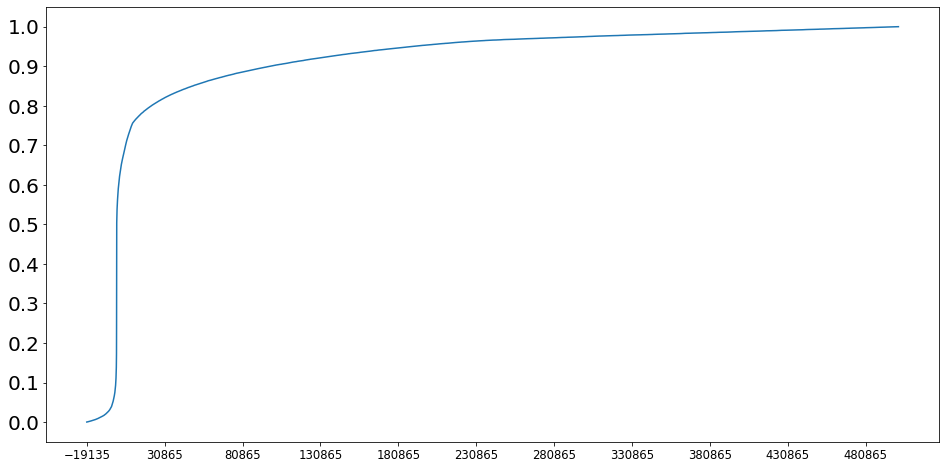

In [96]:
density = gaussian_kde(transformed_srcs[:,0])
xs = np.linspace(np.min(transformed_srcs[:,0]),np.max(transformed_srcs[:,0]),10000)
density.covariance_factor = lambda : .2
density._compute_covariance()
stdev = np.sqrt(density.covariance)[0, 0]
pde_cdf = ndtr(np.subtract.outer(xs,transformed_srcs[:,0])).mean(axis=1)
plt.figure(figsize=(16, 8))
plt.plot(xs, pde_cdf)
plt.xticks(np.arange(min(xs), max(xs)+1, 50000), visible = True, fontsize = "xx-small")
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

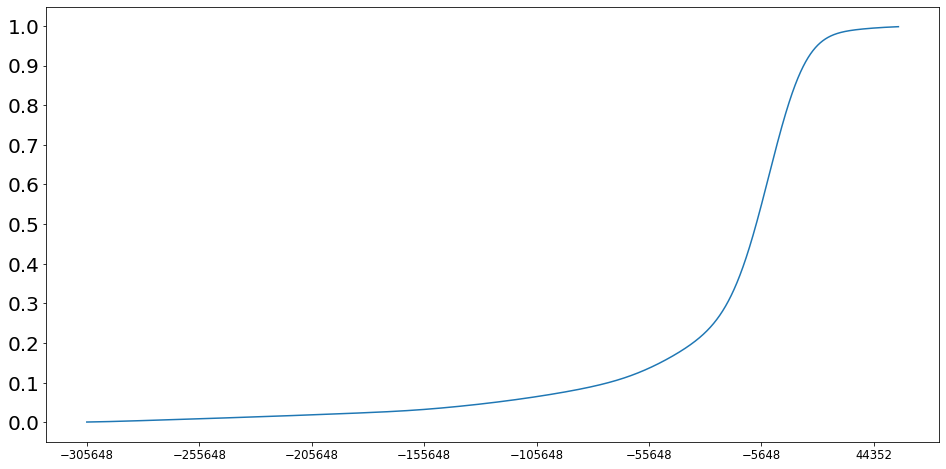

In [88]:
density = gaussian_kde(transformed_srcs[:,1])
xs = np.linspace(np.min(transformed_srcs[:,1]),np.max(transformed_srcs[:,1]),10000)
density.covariance_factor = lambda : .25
density._compute_covariance()
stdev = np.sqrt(density.covariance)[0, 0]
pde_cdf = ndtr(np.subtract.outer(xs,transformed_srcs[:,1])/stdev).mean(axis=1)
plt.figure(figsize=(16, 8))
plt.plot(xs, pde_cdf)
plt.xticks(np.arange(min(xs), max(xs)+1, 50000), visible = True, fontsize = "xx-small")
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

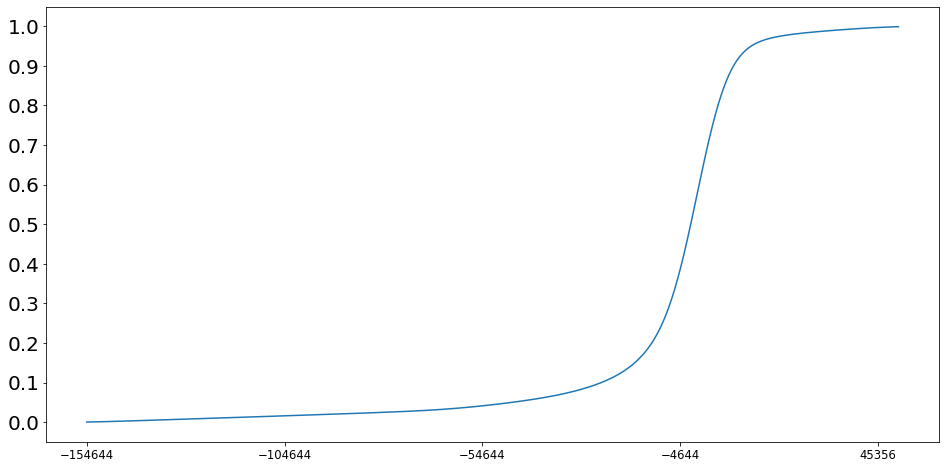

In [87]:
density = gaussian_kde(transformed_srcs[:,2])
xs = np.linspace(np.min(transformed_srcs[:,2]),np.max(transformed_srcs[:,2]),10000)
density.covariance_factor = lambda : .25
density._compute_covariance()
stdev = np.sqrt(density.covariance)[0, 0]
pde_cdf = ndtr(np.subtract.outer(xs,transformed_srcs[:,2])/stdev).mean(axis=1)
plt.figure(figsize=(16, 8))
plt.plot(xs, pde_cdf)
plt.xticks(np.arange(min(xs), max(xs)+1, 50000), visible = True, fontsize = "xx-small")
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

plot cdf of state variable as below

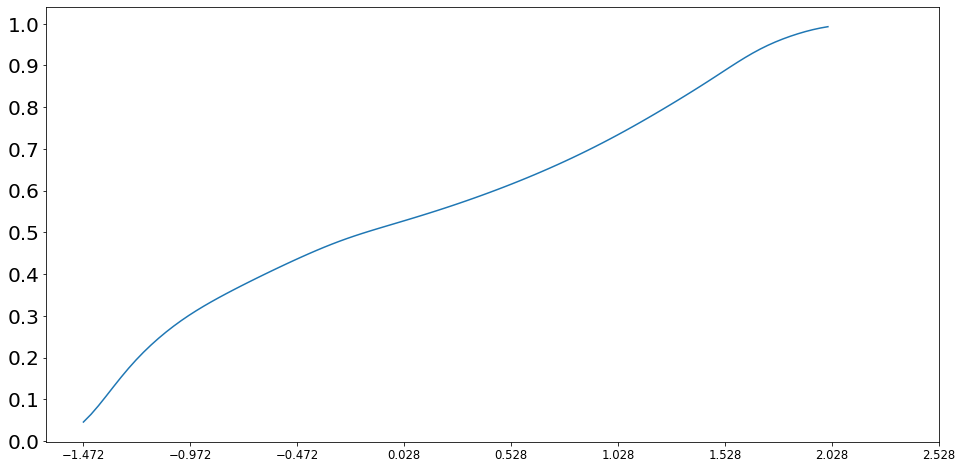

In [86]:
density = gaussian_kde(transformed_mat[:,0])
xs = np.linspace(np.min(transformed_mat[:,0]),np.max(transformed_mat[:,0]),100)
density.covariance_factor = lambda : 0.1
density._compute_covariance()
stdev = np.sqrt(density.covariance)[0, 0]
pde_cdf = ndtr(np.subtract.outer(xs,transformed_mat[:,0])/stdev).mean(axis=1)
plt.figure(figsize=(16, 8))
plt.plot(xs, pde_cdf)
plt.xticks(np.arange(min(xs), max(xs)+1, 0.5), visible = True, fontsize = "xx-small")
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

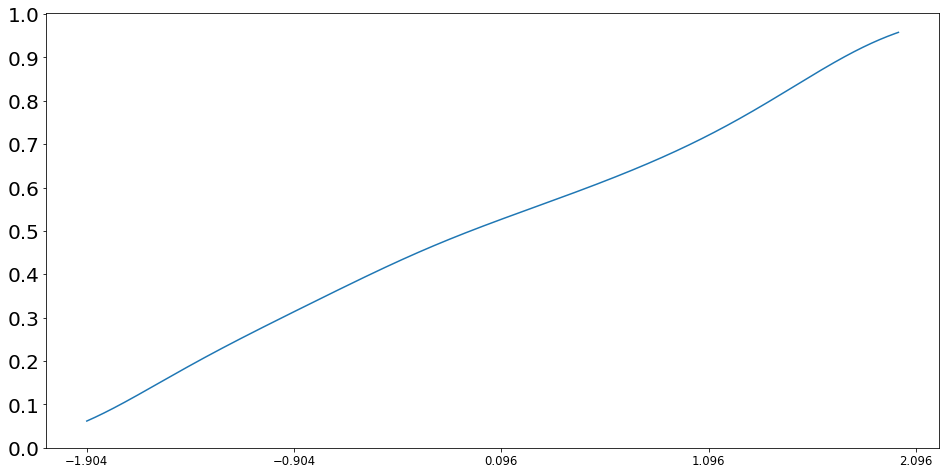

In [98]:
density = gaussian_kde(transformed_mat[:,1])
xs = np.linspace(np.min(transformed_mat[:,1]),np.max(transformed_mat[:,1]),10000)
density.covariance_factor = lambda : .25
density._compute_covariance()
stdev = np.sqrt(density.covariance)[0, 0]
pde_cdf = ndtr(np.subtract.outer(xs,transformed_mat[:,1])/stdev).mean(axis=1)
plt.figure(figsize=(16, 8))
plt.plot(xs, pde_cdf)
plt.xticks(np.arange(min(xs), max(xs)+1, 1), visible = True, fontsize = "xx-small")
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

In [48]:
cv_error, a, b, c, pred, Y_2  = short_result(transformed_mat, transformed_srcs, 0.2, 0.05, 5, 1e-1, 10, False)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:22<01:30, 22.71s/it]

 40%|████      | 2/5 [00:45<01:07, 22.60s/it]

 60%|██████    | 3/5 [01:14<00:49, 24.52s/it]

 80%|████████  | 4/5 [01:36<00:23, 23.89s/it]

100%|██████████| 5/5 [01:58<00:00, 23.80s/it]



Cross-Validation Statistics of 20.0 percent random subsample
+-----------------------+-------------------+-----------------------+--------------------+
|                       |   rmse 5 fold AVG |   r_square 5 fold AVG |   l_inf 5 fold AVG |
|-----------------------+-------------------+-----------------------+--------------------|
| projected dimension 1 |           650.654 |              0.999973 |            8068.65 |
| projected dimension 2 |           446.407 |              0.999535 |            6065.35 |
| projected dimension 3 |           238.685 |              0.999811 |            3278.55 |
+-----------------------+-------------------+-----------------------+--------------------+




Peak locations of the 5.0 percent random subsample
$S_{DML_0}$ peak locations: [0.38321546]
$S_{DML_1}$ peak locations: [0.31083646]
$S_{DML_2}$ peak locations: [0.26185157]


Train/Test random split ratio as 20.0/80.0
+-----------------------+----------+------------+---------+
|                       |     rmse |   r_square |   l_inf |
|-----------------------+----------+------------+---------|
| projected dimension 1 |  690.933 |   0.999922 |  9842.7 |
| projected dimension 2 | 2698.87  |   0.996911 | 20947.6 |
| projected dimension 3 | 1526.03  |   0.995571 | 12049.6 |
+-----------------------+----------+------------+---------+


In [ ]:
cmap = px.colors.diverging.Spectral
# transformed_srcs = dmlVars @ np.real(m)
# transformed_mat = X_scaled @ np.real(m[:-1])

data = \
{
    'DML_1':transformed_mat[:,0],
    'DML_2':transformed_mat[:,1],
    'DML_3':transformed_mat[:,2],
    'Src DML_1': transformed_srcs[:,0],
    'Src DML_2': transformed_srcs[:,1],
    'Src DML_3': transformed_srcs[:,2],
}

# data = \
# {
#     'DML_1':transformed_mat[:,0]/(transformed_mat[:,0].max()-transformed_mat[:,0].min()),
#     'DML_2':transformed_mat[:,1]/(transformed_mat[:,1].max()-transformed_mat[:,1].min()),
#     'DML_3':transformed_mat[:,2]/(transformed_mat[:,2].max()-transformed_mat[:,2].min()),
#     'Src DML_1': transformed_srcs[:,0],
#     'Src DML_2': transformed_srcs[:,1],
#     'Src DML_3': transformed_srcs[:,2],
# }

for name in varNames : data[name] = X[:,varNames.index(name)]
    
stuffToPlot = \
{
    'O2': 'O2',
    'T' : 'Temperature, (K)',
    'H' : 'H mass fraction',
    'Src DML_1': 'DML 1 source',
    'Src DML_2': 'DML 2 source',
    'Src DML_3': 'DML 3 source',
}
for fieldName, title in stuffToPlot.items():
    p = \
    px.scatter_3d(data,
                  x='DML_1', 
                  y='DML_2', 
                  z='DML_3', 
                  color=fieldName,
                  title=title,
                 color_continuous_scale=cmap)
#     p = \
#     px.scatter(data,
#                   x='DML_1', 
#                   y='DML_2', 
#                   color=fieldName,
#                   title=title,
#                  color_continuous_scale=cmap)
    p.show()


In [ ]:
bandwidth_values = np.logspace(-3.5, 0.5, 25)

# Create names for dependent variables:
depvar_names = ['$S_{DML_1}$', '$S_{DML_2}$', '$S_{DML_3}$']


variance_data = analysis.compute_normalized_variance(transformed_mat,
                                                     transformed_srcs,
                                                     depvar_names=depvar_names,
                                                     bandwidth_values=bandwidth_values,
                                                     n_threads=4
                                                    )

# computing normalized variance data
der, sig = analysis.normalized_variance_derivative(variance_data)

# Finding the peak locations of the normalized variance derivative
for depvar_name in depvar_names:
    peak_locs, peak_vals = analysis.find_local_maxima(der[depvar_name], sig, show_plot=False)
    print(depvar_name, 'peak locations:', peak_locs)

In [ ]:
plt = analysis.plot_normalized_variance_comparison((variance_data,), 
                                                   ([], []), 
                                                   ('hsv',), 
                                                   save_filename=None)

plt = analysis.plot_normalized_variance_derivative_comparison((variance_data,), 
                                                   ([], []), 
                                                   ('hsv',), 
                                                   save_filename=None)

below is w.o clustering sampling